In [1]:
!pip install spark

     |████████████████████████████████| 41 kB 204 kB/s 
  Created wheel for spark: filename=spark-0.2.1-py3-none-any.whl size=58738 sha256=d2ef5ba9f0c493d0136c93f2823ea36a0b39720c88587af5f94bfa2849ac1357
  Stored in directory: /Users/sne2909/Library/Caches/pip/wheels/c5/19/ff/9b16f354528bc9698ec3286be7947ebbf1f8391325553961d4
Successfully built spark


In [2]:
!pip install imblearn

     |████████████████████████████████| 206 kB 4.8 MB/s 
     |████████████████████████████████| 7.2 MB 15.4 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.1
    Uninstalling scikit-learn-0.23.1:
      Successfully uninstalled scikit-learn-0.23.1


In [3]:
!pip install pyspark

     |████████████████████████████████| 212.3 MB 57 kB/s 
     |████████████████████████████████| 198 kB 71.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=3e650e1c9e5e6e78d7daaa54fe39db83f4d79199faeb7529e3ec45b21f5325fa
  Stored in directory: /Users/sne2909/Library/Caches/pip/wheels/b3/0e/81/264aeed961e43b9f6ba9ec81c8c540d2d7dccc52c6b51cbf22
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [4]:
from pyspark.sql import SQLContext
from pyspark.sql import DataFrameNaFunctions
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer, VectorIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import avg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.model_selection import train_test_split
from collections import Counter

In [5]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext()
spark = SparkSession(sc)

In [8]:
crime_housing = sqlContext.read.csv("./Crime_Housing.csv", header=True, inferSchema= True) 
crime_housing.columns

['Month',
 'Crimetype',
 'postcode',
 'price_paid',
 'property_type',
 'new_build',
 'town',
 'district']

In [10]:
crime_housing.printSchema()

root
 |-- Month: string (nullable = true)
 |-- Crimetype: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- price_paid: integer (nullable = true)
 |-- property_type: string (nullable = true)
 |-- new_build: string (nullable = true)
 |-- town: string (nullable = true)
 |-- district: string (nullable = true)



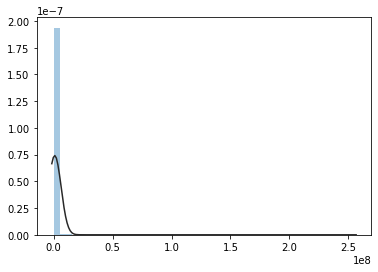

In [25]:
import seaborn as sns
#tO VISUALISE 1D view of my dataset
from scipy.stats import norm
sns.distplot(dataframe_2[['price_paid']], fit=norm, kde=False)

In [28]:
dataframe_1.groupby('Crimetype').count().sort_values('Month', ascending=False)

,Month,postcode,property_type,new_build,town,district
Crimetype,,,,,,
Anti-social behaviour,28256,28256,28256,28256,28256,28256
Violence and sexual offences,23130,23130,23130,23130,23130,23130
Vehicle crime,12724,12724,12724,12724,12724,12724
Burglary,8759,8759,8759,8759,8759,8759
Other theft,8561,8561,8561,8561,8561,8561
Criminal damage and arson,5754,5754,5754,5754,5754,5754
Public order,4719,4719,4719,4719,4719,4719
Drugs,3706,3706,3706,3706,3706,3706
Shoplifting,2980,2980,2980,2980,2980,2980


In [43]:
# replace predictor variable with categorical labels instead... using pandas quantile cut we can do that
crime_housing_clean = crime_housing.toPandas().copy()

pd.qcut(crime_housing_clean['price_paid'], q=[0, .1, 0.25, .5, .75, .9, 1]).unique()

[(220000.0, 317000.0], (99.999, 220000.0], (317000.0, 435000.0], (435000.0, 645000.0], (645000.0, 1100000.0], (1100000.0, 255000000.0]]
Categories (6, interval[float64]): [(99.999, 220000.0] < (220000.0, 317000.0] < (317000.0, 435000.0] < (435000.0, 645000.0] < (645000.0, 1100000.0] < (1100000.0, 255000000.0]]

In [52]:
crime_housing_clean['price_paid_categories'] = pd.qcut(crime_housing_clean['price_paid'], q=[0, .1, 0.25, .5, .75, .9, 1], labels=['< $220k', '$220k - $317k', '$317k - $435k', '$435k - $645k', '$645k - $1.1M', '> $1.1M'])
# extract month from Month (date) column
crime_housing_clean['month_int'] = crime_housing_clean['Month'].apply(lambda x: pd.to_datetime(x).month)

In [53]:
crime_housing_clean.head()

,Month,Crimetype,postcode,price_paid,property_type,new_build,town,district,price_paid_categories,month_int
0,01/11/2019,Anti-social behaviour,RM6 5PJ,250000,T,N,ROMFORD,BARKING AND DAGENHAM,$220k - $317k,1
1,01/11/2019,Anti-social behaviour,RM6 5JJ,215000,F,N,ROMFORD,BARKING AND DAGENHAM,< $220k,1
2,01/11/2019,Burglary,RM6 5JP,290000,T,N,ROMFORD,BARKING AND DAGENHAM,$220k - $317k,1
3,01/11/2019,Criminal damage and arson,RM6 5PJ,250000,T,N,ROMFORD,BARKING AND DAGENHAM,$220k - $317k,1
4,01/11/2019,Criminal damage and arson,RM6 5PJ,250000,T,N,ROMFORD,BARKING AND DAGENHAM,$220k - $317k,1


In [107]:
crime_housing_clean.town.nunique()

72

In [77]:
crime_housing_clean.columns = crime_housing_clean.columns.str.lower()
cols = crime_housing_clean.columns

In [108]:
sdf_crime_housing = spark.createDataFrame(crime_housing_clean)
# Encode categorical variables before test/train split
categoricalCols = ['crimetype','property_type','town','new_build','district']
stages = []

featureIndexers = [StringIndexer(inputCol=catCol, outputCol=catCol+'Index') for catCol in categoricalCols]
stages += featureIndexers

labelIndexer = [StringIndexer(inputCol=labelCol, outputCol='label') for labelCol in ['price_paid_categories']]
stages += labelIndexer

numericCols = ['month_int']

assemblerInputs = [col + 'Index' for col in categoricalCols] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

pipeline = Pipeline(stages=stages)
sdf = pipeline.fit(sdf_crime_housing).transform(sdf_crime_housing)

selectedCols = ['label','features'] + cols.tolist()
sdf = sdf.select(selectedCols)
sdf.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- month: string (nullable = true)
 |-- crimetype: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- price_paid: long (nullable = true)
 |-- property_type: string (nullable = true)
 |-- new_build: string (nullable = true)
 |-- town: string (nullable = true)
 |-- district: string (nullable = true)
 |-- price_paid_categories: string (nullable = true)
 |-- month_int: long (nullable = true)



In [109]:
sdf.show(5)

+-----+--------------------+----------+--------------------+--------+----------+-------------+---------+-------+--------------------+---------------------+---------+
|label|            features|     month|           crimetype|postcode|price_paid|property_type|new_build|   town|            district|price_paid_categories|month_int|
+-----+--------------------+----------+--------------------+--------+----------+-------------+---------+-------+--------------------+---------------------+---------+
|  3.0|[0.0,1.0,1.0,0.0,...|01/11/2019|Anti-social behav...| RM6 5PJ|    250000|            T|        N|ROMFORD|BARKING AND DAGENHAM|        $220k - $317k|        1|
|  4.0|[0.0,0.0,1.0,0.0,...|01/11/2019|Anti-social behav...| RM6 5JJ|    215000|            F|        N|ROMFORD|BARKING AND DAGENHAM|              < $220k|        1|
|  3.0|[3.0,1.0,1.0,0.0,...|01/11/2019|            Burglary| RM6 5JP|    290000|            T|        N|ROMFORD|BARKING AND DAGENHAM|        $220k - $317k|        1|
|  3

In [164]:
# split data in train & test 

train, test = sdf.randomSplit([0.8, 0.2], seed=25)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 107432
Test Dataset Count: 27003


In [165]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3, maxBins=100)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('crimetype','postcode','property_type','new_build','town','district', 'month_int','label','prediction').show(10)

+--------------------+--------+-------------+---------+------+--------+---------+-----+----------+
|           crimetype|postcode|property_type|new_build|  town|district|month_int|label|prediction|
+--------------------+--------+-------------+---------+------+--------+---------+-----+----------+
|Violence and sexu...|SW16 2SN|            F|        N|LONDON| LAMBETH|        1|  0.0|       0.0|
|Violence and sexu...| SW9 9UQ|            F|        N|LONDON| LAMBETH|        1|  0.0|       0.0|
|       Vehicle crime| SW8 2EU|            F|        N|LONDON| LAMBETH|        1|  0.0|       0.0|
|Criminal damage a...|SW16 6JD|            F|        N|LONDON| LAMBETH|        1|  0.0|       0.0|
|             Robbery|SW16 5LJ|            F|        N|LONDON| LAMBETH|        1|  0.0|       0.0|
|       Bicycle theft|SE24 0NS|            F|        N|LONDON| LAMBETH|        1|  0.0|       0.0|
|Anti-social behav...| SW9 8QH|            T|        N|LONDON| LAMBETH|        1|  0.0|       1.0|
|Anti-soci

In [166]:
# evaluate decision tree
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

print("Test Error = %g " % (1.0 - accuracy))
print("Accuracy = %g " % accuracy)

Test Error = 0.65415 
Accuracy = 0.34585 


In [167]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', maxBins=100)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('crimetype','postcode','property_type','new_build','town','district', 'month_int','label','prediction').show(10)

+--------------------+--------+-------------+---------+------+--------+---------+-----+----------+
|           crimetype|postcode|property_type|new_build|  town|district|month_int|label|prediction|
+--------------------+--------+-------------+---------+------+--------+---------+-----+----------+
|Violence and sexu...|SW16 2SN|            F|        N|LONDON| LAMBETH|        1|  0.0|       1.0|
|Violence and sexu...| SW9 9UQ|            F|        N|LONDON| LAMBETH|        1|  0.0|       1.0|
|       Vehicle crime| SW8 2EU|            F|        N|LONDON| LAMBETH|        1|  0.0|       1.0|
|Criminal damage a...|SW16 6JD|            F|        N|LONDON| LAMBETH|        1|  0.0|       1.0|
|             Robbery|SW16 5LJ|            F|        N|LONDON| LAMBETH|        1|  0.0|       1.0|
|       Bicycle theft|SE24 0NS|            F|        N|LONDON| LAMBETH|        1|  0.0|       1.0|
|Anti-social behav...| SW9 8QH|            T|        N|LONDON| LAMBETH|        1|  0.0|       1.0|
|Anti-soci

In [168]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

print("Test Error = %g " % (1.0 - accuracy))
print("Accuracy = %g " % accuracy)

Test Error = 0.598193 
Accuracy = 0.401807 


In [169]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

In [170]:
predictions = lrModel.transform(test)
predictions.select('crimetype','postcode','property_type','new_build','town','district', 'month_int','label','prediction').show(10)

+--------------------+--------+-------------+---------+------+--------+---------+-----+----------+
|           crimetype|postcode|property_type|new_build|  town|district|month_int|label|prediction|
+--------------------+--------+-------------+---------+------+--------+---------+-----+----------+
|Violence and sexu...|SW16 2SN|            F|        N|LONDON| LAMBETH|        1|  0.0|       0.0|
|Violence and sexu...| SW9 9UQ|            F|        N|LONDON| LAMBETH|        1|  0.0|       0.0|
|       Vehicle crime| SW8 2EU|            F|        N|LONDON| LAMBETH|        1|  0.0|       0.0|
|Criminal damage a...|SW16 6JD|            F|        N|LONDON| LAMBETH|        1|  0.0|       0.0|
|             Robbery|SW16 5LJ|            F|        N|LONDON| LAMBETH|        1|  0.0|       0.0|
|       Bicycle theft|SE24 0NS|            F|        N|LONDON| LAMBETH|        1|  0.0|       0.0|
|Anti-social behav...| SW9 8QH|            T|        N|LONDON| LAMBETH|        1|  0.0|       1.0|
|Anti-soci

In [171]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

print("Test Error = %g " % (1.0 - accuracy))
print("Accuracy = %g " % accuracy)

Test Error = 0.714254 
Accuracy = 0.285746 
